### Lecture 4: Homework

Today we gonna learn how to choose between ML models, based on data type. Your task would be to predict **the edibility of a mushroom** based on sample descriptions (binary classification problem)

The **tricky part here is that 95% of the features are of categorical type.**
<br>That's the one where we would **(usually)  prefer tree-based algorithms over linear methods**

Although this dataset was originally contributed to the UCI Machine Learning repository nearly 30 years ago, mushroom hunting (otherwise known as "shrooming") is enjoying new peaks in popularity. Learn which features spell certain death and which are most palatable in this dataset of mushroom characteristics. And how certain can your model be?

This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

More information can be found [here](https://www.kaggle.com/uciml/mushroom-classification/data)

Please find below correspondent [google form](https://docs.google.com/forms/d/e/1FAIpQLScmKfUApMlcD81u9UZxM7xG3vJiEJHrPrG-3b0i_jyPEDijgQ/viewform) to submit your answers

In [451]:
# library import
import pandas as pd
import numpy as np
from os.path import join as pjoin
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 100

#visualisation
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 16, 10

# preprocessing / validation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import classification_report, f1_score

#feature selection
from sklearn.feature_selection import VarianceThreshold

In [452]:
# read data
DATA_DIR = '../data'
df_train = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-train.csv'), engine='c')
df_test = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-test.csv'), engine='c')
print(df_train.shape, df_test.shape)

(6499, 23) (1625, 22)


In [453]:
# let's see what data looks like
df_train.head()

,target,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,0,convex,scaly,brown,bruises,pungent,free,close,narrow,white,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,brown,scattered,urban
1,1,flat,fibrous,gray,bruises,none,free,close,broad,brown,tapering,bulbous,smooth,smooth,white,white,partial,white,one,pendant,brown,several,woods
2,0,flat,smooth,brown,no,none,attached,close,broad,orange,enlarging,missing,smooth,smooth,orange,orange,partial,orange,one,pendant,brown,several,leaves
3,1,convex,fibrous,gray,bruises,none,free,close,broad,brown,tapering,bulbous,smooth,smooth,white,white,partial,white,one,pendant,black,solitary,woods
4,0,knobbed,smooth,brown,no,foul,free,close,narrow,buff,tapering,missing,silky,smooth,pink,pink,partial,white,one,evanescent,white,several,paths


In [454]:
# for convenient calculations, let us merge train with test
df = pd.concat([df_train, df_test], axis=0)
# add column for filtering train/test
df['is_train'] = True
df.loc[df.target.isnull(), 'is_train'] = False
# check shapes
print(df.shape)
# check labels
df.is_train.value_counts()

(8124, 24)


True     6499
False    1625
Name: is_train, dtype: int64

### Task 1. Which feature has the highest amount of unique values? (joint dataset)


In [455]:
# your code goes here
# ---------------------------------------------------------------
most_diversive = df.nunique().argmax()
# ---------------------------------------------------------------

print(most_diversive)

gill_color


### Task 2
**As a preparation, one would spend up to 15-30 minutes on exploratory data analysis (EDA)** - make sure you understand how features are distributed in train/test, what they look like, are they ordinal/binary/categorical before moving further
<br>While doing it, please answer the questions

### Let's look at number of unique features

In [456]:
df.nunique()
#veil_type has only one unique value => useless

bruises                      2
cap_color                   10
cap_shape                    6
cap_surface                  4
gill_attachment              2
gill_color                  12
gill_size                    2
gill_spacing                 2
habitat                      7
odor                         9
population                   6
ring_number                  3
ring_type                    5
spore_print_color            9
stalk_color_above_ring       9
stalk_color_below_ring       9
stalk_root                   5
stalk_shape                  2
stalk_surface_above_ring     4
stalk_surface_below_ring     4
target                       2
veil_color                   4
veil_type                    1
is_train                     2
dtype: int64

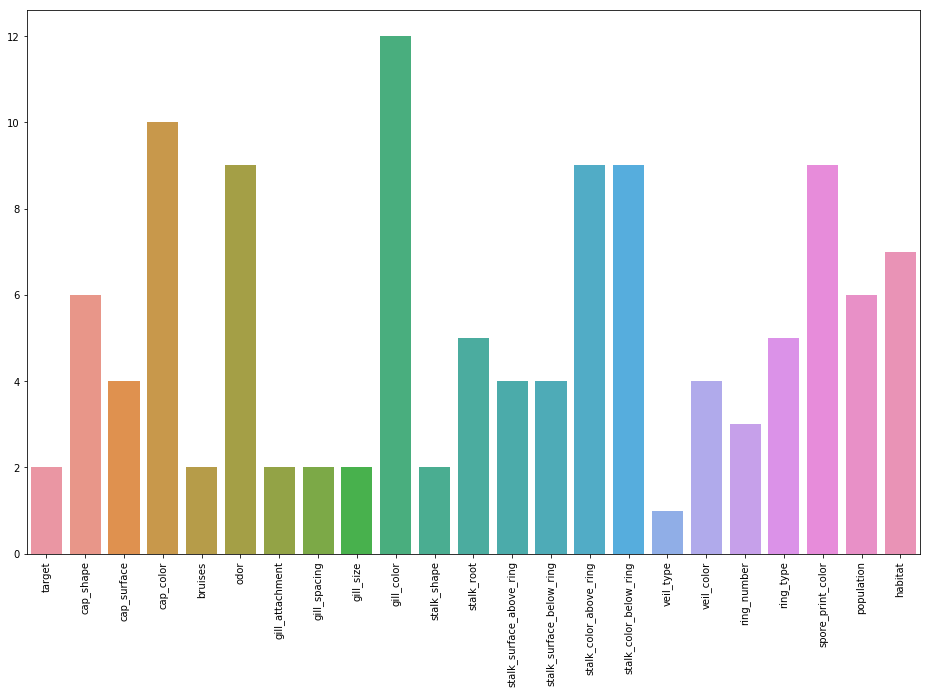

In [457]:
unique = df_train.nunique()
fig = sns.barplot(x=unique.index, y=unique.values)
for x in fig.get_xticklabels():
    x.set_rotation(90) 

## 'veil_type' has only one unique value, so it is useless
### =====================================================

### Let's look at values frequency and distribution of features depend on target

In [458]:
columns = df_train.columns[1:]
for column in columns:
    print(df[column].value_counts(normalize=True), end="\n\n\n")
# veil_color, gill_attachment - one of values has > 0.95 frequency.

convex     0.450025
flat       0.387986
knobbed    0.101920
bell       0.055638
sunken     0.003939
conical    0.000492
Name: cap_shape, dtype: float64


scaly      0.399311
smooth     0.314623
fibrous    0.285574
grooves    0.000492
Name: cap_surface, dtype: float64


brown       0.281142
gray        0.226489
red         0.184638
yellow      0.131955
white       0.128016
buff        0.020679
pink        0.017725
cinnamon    0.005416
purple      0.001969
green       0.001969
Name: cap_color, dtype: float64


no         0.584441
bruises    0.415559
Name: bruises, dtype: float64


none        0.434269
foul        0.265879
spicy       0.070901
fishy       0.070901
almond      0.049237
anise       0.049237
pungent     0.031512
creosote    0.023634
musty       0.004431
Name: odor, dtype: float64


free        0.974151
attached    0.025849
Name: gill_attachment, dtype: float64


close      0.838503
crowded    0.161497
Name: gill_spacing, dtype: float64


broad     0.690793
narrow    0.309207

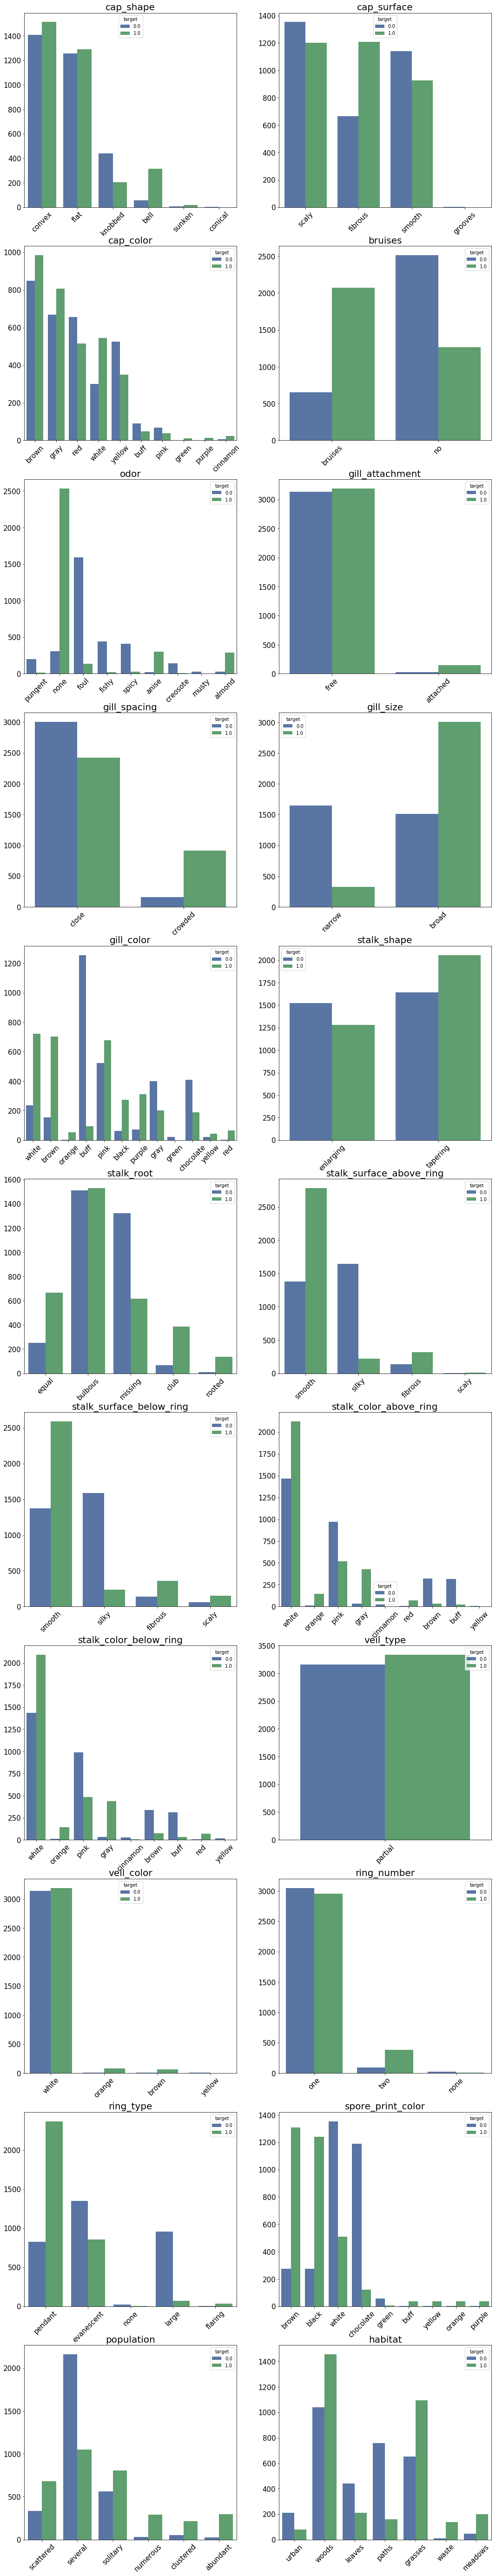

In [459]:
fig, axes = plt.subplots(11,2, figsize=(18,100))
for ax, column in zip(axes.flatten(), columns):
    sns.countplot(data=df[df.is_train], x=column, hue='target', ax=ax, palette = 'deep')
    ax.tick_params(axis = 'x', labelsize = 15, rotation=45)
    ax.tick_params(axis = 'y', labelsize = 15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(column, fontsize=20)

In [462]:
for column in columns:
    print(df[df.is_train].groupby('target')[column].value_counts(normalize=True), end="\n\n\n")

target  cap_shape
0.0     convex       0.444831
        flat         0.396459
        knobbed      0.138792
        bell         0.017389
        sunken       0.001581
        conical      0.000948
1.0     convex       0.453237
        flat         0.386691
        bell         0.094125
        knobbed      0.060552
        sunken       0.005396
Name: cap_shape, dtype: float64


target  cap_surface
0.0     scaly          0.427758
        smooth         0.361050
        fibrous        0.210243
        grooves        0.000948
1.0     fibrous        0.362110
        scaly          0.359712
        smooth         0.278177
Name: cap_surface, dtype: float64


target  cap_color
0.0     brown        0.268416
        gray         0.211192
        red          0.207082
        yellow       0.165666
        white        0.094847
        buff         0.028770
        pink         0.021815
        cinnamon     0.002213
1.0     brown        0.294964
        gray         0.241607
        white       

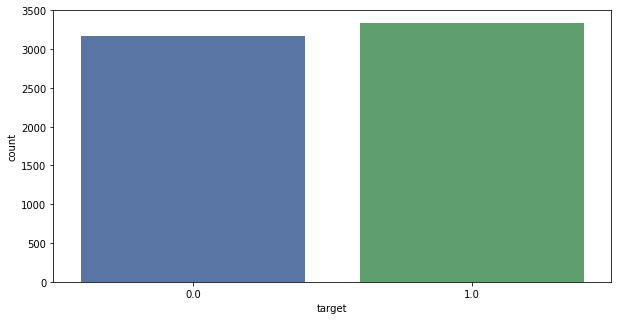

In [493]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(df[df.is_train].target, palette='deep')

#### 2.1 Are there any features, obviously redundant to train on? If yes - what are they and why it's better to remove them?

In [442]:
print(df.shape)
# your code/hardcoded list goes here
# ---------------------------------------------------------------
redundant_columns = ['veil_type']
# ---------------------------------------------------------------
# lets drop these columns from joint dataset
df = df.drop(redundant_columns, axis=1, errors='ignore')
print(df.shape)

(8124, 24)
(8124, 23)


####  2.2 How many features (excluding target variable and train/test indexing columns) are:
- categorical (more than 2 unique values, no explicit ordering)
- ordinal (more than 2 unique values, explicit ordering)
- binary (2 unique values, doesn't matter whether it has ordering or is "yes/no" styled) 

In [464]:
# your code goes here
# ---------------------------------------------------------------
ordinal_cols = sorted(['ring_number'])
binary_cols = sorted(['bruises',
                      'gill_size',
                      'gill_spacing',
                      'stalk_shape',
                      'gill_attachment'])
categorical_cols = sorted(['cap_color',
                           'cap_shape',
                           'cap_surface',
                           'gill_color',
                           'habitat',
                           'odor',
                           'ring_type',
                           'spore_print_color',
                           'stalk_color_above_ring',
                           'stalk_color_below_ring',
                           'stalk_root',
                           'stalk_surface_above_ring',
                           'stalk_surface_below_ring',
                           'population',
                           'veil_color'])
# ---------------------------------------------------------------
print('categorical: {}\nordinal: {}\nbinary: {}'.format(
    len(categorical_cols), len(ordinal_cols), len(binary_cols)))

categorical: 15
ordinal: 1
binary: 5


In [465]:
# To be used in training, data must be properly encoded
from collections import defaultdict

# function to encode categorical data


def __encode_categorical(df_list, cat_cols):
    # initialize placeholder
    d = defaultdict(LabelEncoder)
    # fit and encode train/test,
    codes = pd.concat(
        [df[cat_cols] for df in df_list],
        axis=0
    ).fillna('').apply(
        lambda x: d[x.name].fit(x)
    ),
    # transform encodings to train/test etc
    for df in df_list:
        df[cat_cols] = df[cat_cols].fillna('').apply(
            lambda x: d[x.name].transform(x))


# label encode data (categorical + binary)
__encode_categorical(df_list=[df], cat_cols=categorical_cols+binary_cols)
# make sure you encode the only ordinal column in correct order
df[ordinal_cols[0]] = df[ordinal_cols[0]].map({'none': 0, 'one': 1, 'two': 2})

# define useful feature columns to be used for training
# (union of all columns discussed above)
columns_to_use = ordinal_cols + binary_cols + categorical_cols

### Task 3. Prepare cross-validation strategy and perform comparison of 2 baseline models (linear vs tree-based)

### =====================================================
#### Briefly about Validation / Cross-Validation

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but **would fail to predict anything useful on yet-unseen data. This situation is called overfitting**. 
<br>To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set ```X_test, y_test```. 
<br>Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally.

When evaluating different settings (“hyperparameters”) for estimators, **there is still a risk of overfitting on the test set** because the parameters can be tweaked until the estimator performs optimally. 
<br>This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. 
<br>To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, **we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.**

A solution to this problem is a procedure called **cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV**. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using k-1 of the folds as training data;
- the resulting model is validated on the remaining part of the data 
<br>(i.e., it is used as a test set to compute a performance measure such as accuracy).
        
<img src="https://hsto.org/files/b1d/706/e6c/b1d706e6c9df49c297b6152878a2d03f.png"/ style="width:75%">

The performance measure reported by k-fold cross-validation **is then the average of the values computed in the loop**. 
<br>This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.


Some classification problems can **exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples**. 
<br>In such cases it is recommended to use **stratified sampling** as implemented in sklearn's StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

More details about different cross-validation strategies, implemented in sklearn, can be found [here](http://scikit-learn.org/stable/modules/cross_validation.html)
### =====================================================

Prepare KFold with 5 splits, stratified by target variable, shuffled, with fixed random_state = 42
<br>**Don't forget to filter by column 'is_train'!**
<br>Fit models on subset of features: [columns_to_use]

In [445]:
from os import cpu_count

n_jobs = max(cpu_count()-1, 1)
# your code goes here
# ---------------------------------------------------------------
# cross-validation iterator
kf = StratifiedKFold(shuffle=True,
                     random_state=42,
                     n_splits=5)
# xtrain, ytrain, DataFrame-like
xtrain = df[df.is_train][columns_to_use]
ytrain = df[df.is_train].target
# ---------------------------------------------------------------

# create Decision Tree with default params, max_depth=3, random_state=42
dt = DecisionTreeClassifier(max_depth=3,
                            random_state=42)

# estimate its f1-score with cross-validation (cross_val_score)
# your code goes here
# ---------------------------------------------------------------
scores_dt = cross_val_score(
    estimator=dt,
    X=xtrain, 
    y=ytrain, 
    scoring='f1', 
    cv=kf, # cross-validation strategy
    n_jobs=n_jobs).mean()
print('DT scoring: {:.2f}'.format(scores_dt))
# ---------------------------------------------------------------


# create Logistic Regression with default params, random_state=42
lr = LogisticRegression(random_state=42)

# estimate its f1-score with cross-validation
# your code goes here
# ---------------------------------------------------------------
scores_lr = cross_val_score(
    estimator=lr,
    X=xtrain, 
    y=ytrain,
    scoring='f1',
    cv=kf,
    n_jobs=n_jobs
).mean()
print('LR scoring: {:.2f}'.format(scores_lr))

DT scoring: 0.90
LR scoring: 0.89


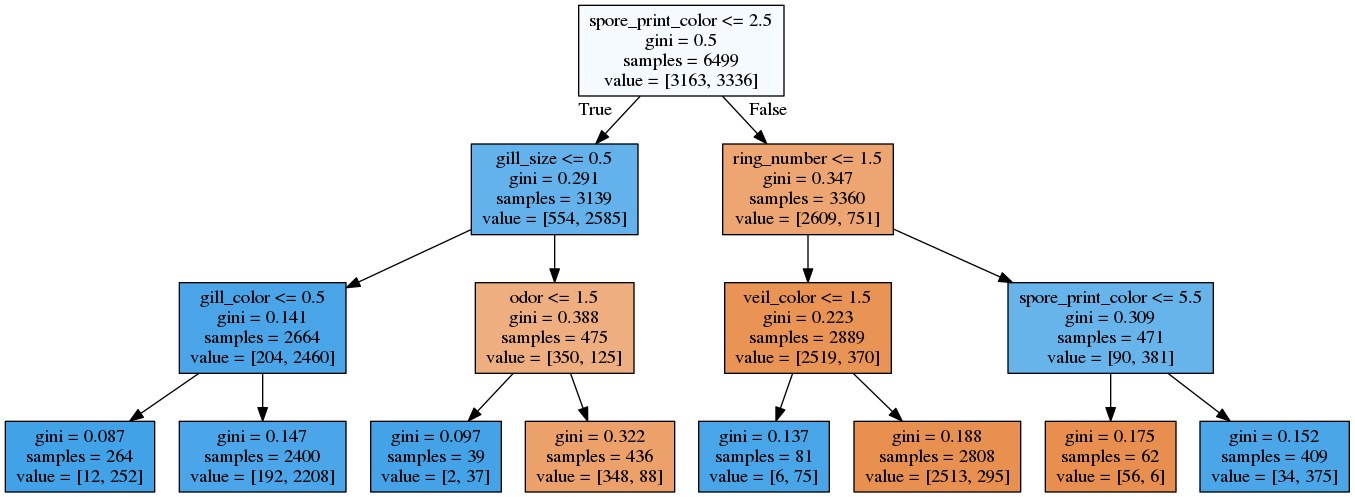

In [446]:
from sklearn.tree import export_graphviz
from IPython.display import Image
dt.fit(xtrain,ytrain)
export_graphviz(dt, 
                feature_names=columns_to_use, 
                out_file='tree.dot',
                filled=True)

!dot -Tpng tree.dot -o tree.png

Image('tree.png')

Why is a score of Linear Regression lower than correspondent one of DT?
1. Is everything OK with the data format for linear models? (revision of 2 previous lectures). 
1. If not, what else you should do to use the data appropriately for linear models?
1. Why didn't point 1. affect Decision Tree performance?

### Task 4. Now it's time to do some hyperparam tuning
Perform suitable hyperparam tuning using created above cross-validation strategy
<br>Main parameters to perform grid-search for:
- max_depth (1,2,...None)
- min_samples_leaf (1,2,...)
- criterion (gini, entropy)
- weight (none, balanced)
- max_features (sqrt(features), 50%, 75%, all of them, ...)
- other params available, see documentation

So - use your fantasy for filling-in abovementioned lists

You should receive **a gain of 0.01 in f1-score or higher**
<br>(current benchmark = +0.0268 gain)

## Decision tree  (first, but the best (find more downpage))

In [346]:
%%time
# your code goes here
# ---------------------------------------------------------------
# create base model (DT, random state = 42)
estimator = DecisionTreeClassifier(random_state=42, class_weight='balanced')
# create parameter grid
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
params = {"max_depth" : range(5,10),
          "min_samples_leaf" :  range(5,8),
          "max_features" : ('sqrt',4,6,8),
          "criterion" : ('gini', 'entropy'),
          "presort" : (True, False),
          "min_samples_split" : range(2,22,2)
         }

# create grid search object
gs = GridSearchCV(
    estimator=estimator,  # base model
    param_grid=params,  # params grid to search within
    cv=kf,  # cross-validation strategy
    error_score=1,  # warnings only
    scoring='f1',  # f1-score
    # thread count, the higher count - the faster
    n_jobs=n_jobs,
    verbose=1,  # messages about performed actions
)

# perform grid search on TRAIN dataset ('is_train' filtering)
gs.fit(
    X=xtrain, 
    y=ytrain, 
)
# -------------------------------------------------------------
# extract best score on cross-validation
best_score = gs.best_score_
# extract the estimator (DT) with best params on cross-validation
best_dt = gs.best_estimator_
# check gain in f1-score
print('f1-score best: {:.4f}, +{:.4f} better than baseline'.format(
    best_score, (best_score - scores_dt))
)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=3)]: Done 706 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 3706 tasks      | elapsed:   19.3s
[Parallel(n_jobs=3)]: Done 8706 tasks      | elapsed:   50.1s
[Parallel(n_jobs=3)]: Done 12000 out of 12000 | elapsed:  1.2min finished


f1-score best: 0.9282, +0.0270 better than baseline
CPU times: user 10.3 s, sys: 351 ms, total: 10.6 s
Wall time: 1min 11s


In [347]:
# take a look on the best model, compare with the baseline
best_dt

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [348]:
# check performance on holdout dataset, unseen before (filter 'is_train' == False)

# your code goes here
# ---------------------------------------------------------------
# appropriate df_test data subset from 'df' dataframe
xtest = df[df.is_train == False][columns_to_use]
# fit baseline model 'dt' on xtrain, ytrain (because it's not fitted yet)
dt.fit(xtrain, ytrain)
# ---------------------------------------------------------------

# baseline model
y_true = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-y_test.csv'))
y_pred_baseline = dt.predict(xtest)

print('Base on train:   {:.4f}\nBase on holdout: {:.4f}\ndiff: {:.4f}'.format(
    scores_dt, 
    f1_score(y_true, y_pred_baseline),
    scores_dt - f1_score(y_true, y_pred_baseline)
))

# best model
y_pred_best = best_dt.predict(xtest)

print('\nBest on train:   {:.4f}\nBest on holdout: {:.4f}\ndiff: {:.4f}'.format(
    best_score, 
    f1_score(y_true, y_pred_best),
    best_score - f1_score(y_true, y_pred_best)
))
f1_score_dt = f1_score(y_true, y_pred_best)

Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9282
Best on holdout: 0.9205
diff: 0.0077


Now you can see that 
<br>**absolute values of f1-score is higher and distance between train|holdout is lower** <br>for **best model** in comparison to **baseline**

# Trying to improve

## Deeper feature selection (finding features that we can drop, but it is not OBVIOUSLY)

### SelectFromModel (bad transform) -> bad try

In [349]:
#just for me
#why?

from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(estimator=DecisionTreeClassifier(random_state=42, max_depth=3))
x_new = sfm.fit_transform(xtrain, ytrain)

scores_dt_sfm = cross_val_score(
    estimator=dt,
    X=x_new, 
    y=ytrain, 
    scoring='f1', 
    cv=kf, # cross-validation strategy
    n_jobs=-1).mean()
print('DT scoring(x transformed): {:.4f}'.format(scores_dt_sfm))

print('DT scoring(usual x): {:.4f}'.format(scores_dt))

DT scoring(x transformed): 0.8968
DT scoring(usual x): 0.9012


### Exploratory

In [350]:
scores_val = []
for column in columns_to_use:
    print("without ", column) 
    columns_to_use_temp = [x for x in columns_to_use if x != column]
    n_jobs = max(cpu_count()-1, 1)
    xtrain = df[df.is_train][columns_to_use_temp]
    ytrain = df[df.is_train].target
    
    
    dt = DecisionTreeClassifier(max_depth=4,
                                random_state=42)

    scores_dt_without = cross_val_score(
        estimator=dt,
        X=xtrain, 
        y=ytrain, 
        scoring='f1', 
        cv=kf, 
        n_jobs=n_jobs).mean()
    print('DT scoring: {:.4f}'.format(scores_dt_without))
    scores_val.append(scores_dt_without)
scores = dict(zip(columns_to_use, scores_val))
scores['base'] = scores_dt

without  ring_number
DT scoring: 0.9140
without  bruises
DT scoring: 0.9176
without  gill_attachment
DT scoring: 0.9176
without  gill_size
DT scoring: 0.9216
without  gill_spacing
DT scoring: 0.9140
without  stalk_shape
DT scoring: 0.9176
without  cap_color
DT scoring: 0.9176
without  cap_shape
DT scoring: 0.9176
without  cap_surface
DT scoring: 0.9168
without  gill_color
DT scoring: 0.9176
without  habitat
DT scoring: 0.9176
without  odor
DT scoring: 0.9176
without  population
DT scoring: 0.9145
without  ring_type
DT scoring: 0.9176
without  spore_print_color
DT scoring: 0.9192
without  stalk_color_above_ring
DT scoring: 0.9176
without  stalk_color_below_ring
DT scoring: 0.9176
without  stalk_root
DT scoring: 0.9176
without  stalk_surface_above_ring
DT scoring: 0.9176
without  stalk_surface_below_ring
DT scoring: 0.9176
without  veil_color
DT scoring: 0.9175


In [351]:
scores

{'base': 0.90122785674838146,
 'bruises': 0.91763554654535873,
 'cap_color': 0.91763554654535873,
 'cap_shape': 0.91763554654535873,
 'cap_surface': 0.9168145276054972,
 'gill_attachment': 0.91763554654535873,
 'gill_color': 0.91763554654535873,
 'gill_size': 0.92160474023431538,
 'gill_spacing': 0.91396032432038565,
 'habitat': 0.91763554654535873,
 'odor': 0.91763554654535873,
 'population': 0.91454011223981035,
 'ring_number': 0.91401606395860513,
 'ring_type': 0.91763554654535873,
 'spore_print_color': 0.91917859066152663,
 'stalk_color_above_ring': 0.91763554654535873,
 'stalk_color_below_ring': 0.91763554654535873,
 'stalk_root': 0.91763554654535873,
 'stalk_shape': 0.91763554654535873,
 'stalk_surface_above_ring': 0.91763554654535873,
 'stalk_surface_below_ring': 0.91763554654535873,
 'veil_color': 0.91749553117781846}

In [468]:
xtrain = df[df.is_train][columns_to_use]
ytrain = df[df.is_train].target
ordinal_cols_new = sorted(['ring_number'])
binary_cols_new = sorted(['gill_spacing'])
categorical_cols_new = sorted(['cap_surface',
                               'gill_color',
                               'habitat',
                               'odor',
                               'spore_print_color',
                               'population',
                               'veil_color'])
columns_to_use_new = ordinal_cols_new + categorical_cols_new + binary_cols_new

xtrain_preselect = xtrain[columns_to_use_new]
xtest_preselect = xtest[columns_to_use_new]

## One-hot encoding

In [355]:
enc_train = pd.get_dummies(df_train[categorical_cols])
enc_test =  pd.get_dummies(df_test[categorical_cols])

X_onehot_train = pd.concat([df[df.is_train][ordinal_cols+binary_cols], 
                       enc_train], 
                       axis=1, 
                       join_axes=[df[df.is_train].index])
X_onehot_test = pd.concat([df[df.is_train == False][ordinal_cols+binary_cols], 
                       enc_test], 
                       axis=1, 
                       join_axes=[df[df.is_train == False].index])

## All-in-one-method

In [356]:
def calculate(model, parameters, X_train, X_test, y_train, ytrue):
    
    gs = GridSearchCV(
    estimator=model,
    param_grid=parameters, 
    cv=kf, 
    error_score=1,  
    scoring='f1',  
    n_jobs=3,
    verbose=1)

    gs.fit(X=X_train, y=y_train)

    
    best_score = gs.best_score_
    best_model = gs.best_estimator_
    
    print('f1-score best: {:.4f}, +{:.4f} better than baseline'.format(best_score, (best_score - scores_dt)))
    
    print('Base on train:   {:.4f}\nBase on holdout: {:.4f}\ndiff: {:.4f}'.format(
        scores_dt, 
        f1_score(ytrue, y_pred_baseline),
        scores_dt - f1_score(ytrue, y_pred_baseline)
    ))

    # best model
    y_pred_best = best_model.predict(X_test)

    print('\nBest on train:   {:.4f}\nBest on holdout: {:.4f}\ndiff: {:.4f}'.format(
        best_score, 
        f1_score(ytrue, y_pred_best),
        best_score - f1_score(ytrue, y_pred_best)
    ))
    return best_model, best_score, f1_score(ytrue, y_pred_best)


## XGBoost

In [490]:
from xgboost import XGBClassifier


params_xgb = {
    "max_depth" : (5,10,15),
    "learning_rate" : np.linspace(0.1,1,num=8),
    "n_estimators" : (5,10,20),
    "booster" : ('gbtree', 'gblinear', 'dart')
}

xgb = XGBClassifier(random_state=42)
best_xgb, best_score_xgb, f1_score_xgb = calculate(xgb, params_xgb, xtrain,xtest,ytrain, y_true)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=3)]: Done 158 tasks      | elapsed:    6.1s
[Parallel(n_jobs=3)]: Done 842 tasks      | elapsed:   26.2s


f1-score best: 0.9280, +0.0268 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9280
Best on holdout: 0.9205
diff: 0.0075


[Parallel(n_jobs=3)]: Done 1080 out of 1080 | elapsed:   41.3s finished


In [489]:
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.27142857142857146,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### With one-hot encoding

In [358]:
params_xgb_onehot = {
    "max_depth" : (5,10,15),
    "learning_rate" : np.linspace(0.4,0.8,num=8),
    "n_estimators" : (30,35),
    "booster" : ('gbtree', 'gblinear', 'dart')
}
best_xgb_one_hot, best_score_xgb_one_hot, f1_score_xgb_onehot = calculate(xgb, params_xgb_onehot, X_onehot_train,
                                                                          X_onehot_test, ytrain, y_true)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   18.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 720 out of 720 | elapsed:  4.4min finished


f1-score best: 0.9282, +0.0269 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9282
Best on holdout: 0.9205
diff: 0.0077


### With preselect

In [360]:
best_xgb_preselect, best_score_xgb_preselect, f1_score_preselect = calculate(xgb, params_xgb, xtrain_preselect,
                                                                          xtest_preselect, ytrain, y_true)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 1080 out of 1080 | elapsed:   22.3s finished


f1-score best: 0.9280, +0.0268 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9280
Best on holdout: 0.9205
diff: 0.0075


## KNN

In [361]:
from sklearn.neighbors import KNeighborsClassifier

params_knn = {'n_neighbors': (9, 10, 11, 12, 13), 
              'algorithm': ('ball_tree', 'kd_tree', 'brute'),
              'leaf_size': (25,27,30),
              'p':(1, 2)}

knn = KNeighborsClassifier(weights='distance')

best_knn, best_score_knn, f1_score_knn_holdout = calculate(knn, params_knn, xtrain,xtest,ytrain, y_true)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   42.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  1.8min


f1-score best: 0.9277, +0.0265 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9277
Best on holdout: 0.9199
diff: 0.0078


[Parallel(n_jobs=3)]: Done 450 out of 450 | elapsed:  1.9min finished


### With one-hot

In [362]:
params_knn_onehot = {'n_neighbors': (5,10), 
              'algorithm': ('ball_tree', 'kd_tree', 'brute'),
              'leaf_size': (25,27,30),
              'p':(1, 2)}
best_knn_onehot, best_score_knn_onehot, f1_score_knn_holdout_onehot = calculate(knn, params_knn_onehot, X_onehot_train,
                                                                               X_onehot_test,ytrain, y_true)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:  5.4min finished


f1-score best: 0.9280, +0.0268 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9280
Best on holdout: 0.9205
diff: 0.0075


## SVC

In [363]:
from sklearn.svm import SVC


params_svc = {'gamma': (0.001, 0.01, 0.1, 1),
               'C': (1, 2, 3, 5, 7)}

svc = SVC(random_state=42, kernel = 'rbf')

best_svc, best_score_svc, f1_score_svc_holdout = calculate(svc, params_svc, xtrain,xtest,ytrain, y_true)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.4min finished


f1-score best: 0.9280, +0.0268 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9280
Best on holdout: 0.9205
diff: 0.0075


### With one-hot encoding

In [364]:
best_svc_onehot, best_score_svc_onehot, f1_score_svc_holdout_onehot = calculate(svc, params_svc, X_onehot_train,
                                                                                X_onehot_test,ytrain, y_true)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  4.0min finished


f1-score best: 0.9279, +0.0266 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9279
Best on holdout: 0.9205
diff: 0.0074


### With preselecting

In [365]:
best_svc_preselect, best_score_svc_preselect, f1_score_svc_holdout_preselect = calculate(svc, params_svc, xtrain_preselect,
                                                                               xtest_preselect,ytrain, y_true)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   17.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   38.0s finished


f1-score best: 0.9280, +0.0268 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9280
Best on holdout: 0.9205
diff: 0.0075


## Random Forest

In [382]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {"max_depth" : (6,8,None),
              "min_samples_leaf" :  range(5,8),
              "max_features" : (15,21),
              "criterion" : ('gini', 'entropy'),
              "n_estimators": (100, 250)}

rf = RandomForestClassifier(random_state=42)

best_rf, best_score_rf, f1_score_rf = calculate(rf, params_rf, xtrain,xtest,ytrain, y_true)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   16.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 360 out of 360 | elapsed:  3.1min finished


f1-score best: 0.9280, +0.0268 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9280
Best on holdout: 0.9205
diff: 0.0075


## Bagging

In [486]:
from sklearn.ensemble import BaggingClassifier

params_bc = {"n_estimators" : (10,30,50),
             "bootstrap": (True, False),
             "bootstrap_features" : (True, False)}
bc = BaggingClassifier(base_estimator=best_dt,random_state=42)

best_bc, best_score_bc, f1_score_bc = calculate(bc, params_bc, xtrain,xtest,ytrain, y_true)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    4.7s finished


f1-score best: 0.9280, +0.0268 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9280
Best on holdout: 0.9205
diff: 0.0075


## Logistic regression one-hot encoding

In [487]:
params_lr = {'C':np.linspace(0.5,5,num=10)}
best_lr, best_score_lr, f1_score_lr = calculate(lr, params_lr, X_onehot_train,X_onehot_test,ytrain, y_true)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1-score best: 0.9282, +0.0269 better than baseline
Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9282
Best on holdout: 0.9205
diff: 0.0077


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    2.8s finished


## Let's summarize

In [491]:
models = ["Decision Tree", "xgboost","KNN", "SVC", "RF", "Bagging", "LR"]
usual_cv = [best_score, best_score_xgb, best_score_knn, best_score_svc, best_score_rf, best_score_bc, None]
usual_holdout = [f1_score_dt, f1_score_xgb, f1_score_knn_holdout, f1_score_svc_holdout, f1_score_rf, f1_score_bc, None]
onehot_cv = [None, best_score_xgb_one_hot, best_score_knn_onehot, best_score_svc_onehot, None, None, best_score_lr]
onehot_holdout=[None, f1_score_xgb_onehot, f1_score_knn_holdout_onehot, f1_score_svc_holdout_onehot, None, None,f1_score_lr]
preselect_cv =[None, best_score_xgb_preselect,None, best_score_svc_preselect, None,None, None]
preselect_holdout=[None, f1_score_preselect, None, f1_score_svc_holdout_preselect, None,None, None ]

summary = pd.DataFrame()
summary['model'] = models
summary['usual_cv'] = usual_cv
summary['usual_holdout'] = usual_holdout
summary['onehot_cv'] = onehot_cv
summary['onehot_holdout'] = onehot_holdout
summary['preselect_cv'] = preselect_cv
summary['preselect_holdout'] = preselect_holdout
#если создавать через словарь - сортирует
summary

,model,usual_cv,usual_holdout,onehot_cv,onehot_holdout,preselect_cv,preselect_holdout
0,Decision Tree,0.928192,0.920482,NaN,NaN,NaN,NaN
1,xgboost,0.927998,0.920482,0.928174,0.920482,0.927998,0.920482
2,KNN,0.927705,0.919928,0.927996,0.920482,NaN,NaN
3,SVC,0.927998,0.920482,0.927857,0.920482,0.927998,0.920482
4,RF,0.927998,0.920482,NaN,NaN,NaN,NaN
5,Bagging,0.927998,0.920482,NaN,NaN,NaN,NaN
6,LR,NaN,NaN,0.928174,0.920482,NaN,NaN


P.S. Если в параметр грид брать другие фичи - можно получить 0.9283 на кроссвалидации, считает по кучу часов, на холдауте в итоге хуже.

## Voting Classifier

In [398]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

vc = VotingClassifier(estimators=[('dt', best_dt), ('xgb', best_xgb),
('rf', best_rf)], voting='soft', n_jobs=4)

vc.fit(xtrain, ytrain)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
      ...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=4, voting='soft', weights=None)

In [399]:
y_pred_v = vc.predict(xtest)
f1_score(y_true, y_pred_v)

0.92048192771084336

## Bonus_question


Bonus question

Consider two possibilities:
- (a) you have trained **one best** (on cross-validation) Decision Tree
- (b) you randomly choose 25 subsets of 70% of training data, fits "overfitted" (max_depth=None) Decision Trees on it - each of them performs slightly worse than Tree in (a), and then average predicted results over all 25 models (overfitted trees)

**Which one of them would most likely give the best results on hold-out dataset? What makes you think that way?**

In [424]:
from sklearn.model_selection import train_test_split
y_pred = []
dt_ov = DecisionTreeClassifier(max_depth=None)
for i in range(25):
    xtr, xt, ytr, yt = train_test_split(xtrain, ytrain, test_size=0.3)
    dt_ov.fit(xtr, ytr)
    y_pred.append(dt_ov.predict(xtest))

In [425]:
y_p = np.array(y_pred).transpose().mean(axis=1)
y_p_n = [1 if x>=0.5 else 0 for x in y_p]
f1_score(y_true, y_p_n)

0.89776164549304294